<p><font size="6"><b>Interactive or web-based visualization</b></font></p>


> *DS Python for GIS and Geoscience*  
> *November, 2022*
>
> *© 2022, Joris Van den Bossche and Stijn Van Hoey. Licensed under [CC BY 4.0 Creative Commons](https://creativecommons.org/licenses/by/4.0/)*

---

In the course, we used the Matplotlib library for all visualizations. This is the library that is most widely used and integrated into the other packages (e.g. the plotting functionality of pandas, geopandas, xarray, rasterio, etc all use matplotlib), and is still the "go to" library for making high-quality, publication graphics. 

There are, however, a bunch of alternatives to matplotlib, mainly focusing on providing more interactivity and based on web (javascript) tools. To many such packages exist to cover in this course, but we list here a few that can handle (to some extent) geospatial data:

- Bokeh: https://bokeh.pydata.org/en/latest/docs/gallery/texas.html
- GeoViews (other interface to Bokeh/matplotlib): http://geo.holoviews.org
- Altair: https://altair-viz.github.io/gallery/index.html#maps
- Plotly: https://plot.ly/python/#maps
- ...


Altair and Plotly are mostly useful for vector data. Using bokeh through holoviews with raster data is shown below.

In [1]:
%matplotlib inline

import pandas as pd
import geopandas

import matplotlib.pyplot as plt

In [2]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
countries = countries[(countries['pop_est'] >0 ) & (countries['name'] != "Antarctica")]
countries['gdp_per_cap'] = countries['gdp_md_est'] / countries['pop_est'] * 100
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("zip://./data/ne_50m_rivers_lake_centerlines.zip")

## Vector data with Leaflet

Another popular javascript library for online maps is [Leaflet.js](https://leafletjs.com/), and this has python bindings in the [folium](https://github.com/python-visualization/folium) and [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) packages.

An example with ipyleaflet:

In [3]:
import ipyleaflet

In [4]:
m = ipyleaflet.Map(center=[48.8566, 2.3429], zoom=6)

layer = ipyleaflet.GeoJSON(data=cities.__geo_interface__)
m.add_layer(layer)
m

Map(center=[48.8566, 2.3429], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

In [5]:
m = ipyleaflet.Map(center=[48.8566, 2.3429], zoom=3)
geo_data = ipyleaflet.GeoData(
    geo_dataframe = countries,
    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    name = 'Countries')
m.add_layer(geo_data)
m

Map(center=[48.8566, 2.3429], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

More: https://ipyleaflet.readthedocs.io/en/latest/api_reference/geodata.html

An example with folium:

In [6]:
import folium

In [7]:
m = folium.Map([48.8566, 2.3429], zoom_start=6, tiles="OpenStreetMap")
folium.GeoJson(countries).add_to(m)
folium.GeoJson(cities).add_to(m)
m

In [8]:
m = folium.Map([0, 0], zoom_start=1)
folium.Choropleth(geo_data=countries, data=countries, columns=['iso_a3', 'gdp_per_cap'],
             key_on='feature.properties.iso_a3', fill_color='BuGn', highlight=True).add_to(m)
m

## Using Holoviews for raster data with xarray

The Holoviews project (http://holoviews.org/) is a set of packages built on top of Bokeh, and which integrate with many of the other packages (pandas, GeoPandas, xarray) through the `hvplot` package (https://hvplot.holoviz.org/) and [GeoViews](https://geoviews.org/).

Using the Gent example Sentinel data to showcase hvplot integration with xarray:

In [9]:
import xarray as xr

import hvplot.xarray
import cartopy.crs as ccrs

In [10]:
gent = xr.open_dataarray("./data/gent/raster/2020-09-17_Sentinel_2_L1C_B0408.tiff", engine="rasterio", mask_and_scale=False)
gent = gent.assign_coords(band=("band", ["b4", "b8"]))

Using the default xarray Matplotlib integration with the `.plot.imshow` method:

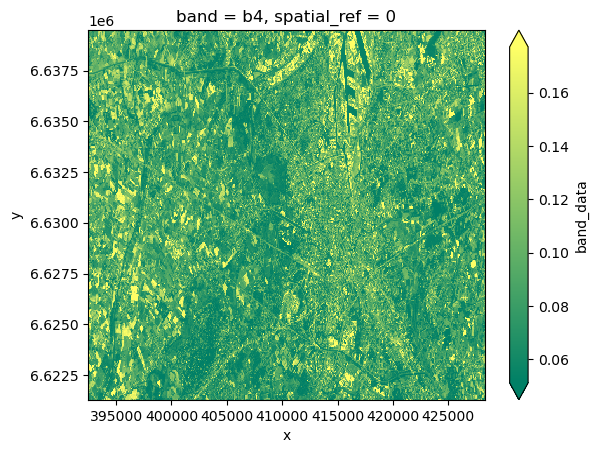

In [11]:
gent.sel(band="b4").plot.imshow(robust=True, cmap="summer")

The equivalent method in hvplot is `.hvplot.image` (and linking the coordinate names):

In [12]:
gent.sel(band="b4").hvplot.image(x="x", y="y", cmap="summer", 
                                 clim=(0.05, 0.2))  # 'robust' option is not available

:Image   [x,y]   (band_data)

hvplot/geoviews translates multiple dimensions (in this case the bands) automatically in a drop-down menu:

In [13]:
gent.hvplot.image(x="x", y="y", cmap="summer", # groupby="band" # adding groupby makes this explicit instead of 'automagically'
                  clim=(0.05, 0.2))  # 'robust' option is not available

:DynamicMap   [band]
   :Image   [x,y]   (band_data)

Similar to matplotlib plots using cartopy (see notebook `visualization-03-cartopy.ipynb`), the CRS information can be used.

From https://hvplot.holoviz.org/user_guide/Geographic_Data.html#declaring-an-output-projection:

> The `crs=` argument specifies the input projection, i.e. it declares how to interpret the incoming data values. You can independently choose any output projection, i.e. how you want to map the data points onto the screen for display, using the `projection=` argument.

In [14]:
gent.rio._crs = False  # small bug in hvplot's handling of rioxarray crs
gent.hvplot.image(x="x", y="y", cmap="summer", 
                  frame_height=400, 
                  crs=ccrs.epsg(3857), 
                  projection=ccrs.UTM(zone=31), 
                  project=True, geo=True,
                  clim=(0.05, 0.2))

:DynamicMap   [band]
   :Image   [x,y]   (band_data)

From https://hvplot.holoviz.org/user_guide/Geographic_Data.html#declaring-an-output-projection:

> Note that when displaying raster data in a projection other than the one in which the data is stored, it is more accurate to render it as a quadmesh rather than an image. As you can see above, a QuadMesh will project each original bin or pixel into the correct non-rectangular shape determined by the projection, accurately showing the geographic extent covered by each sample. An Image, on the other hand, will always be rectangularly aligned in the 2D plane, which requires warping and resampling the data in a way that allows efficient display but loses accuracy at the pixel level. Unfortunately, rendering a large QuadMesh using Bokeh can be very slow

In [ ]:
gent.hvplot.quadmesh(x="x", y="y", cmap="summer", 
                     frame_height=400, 
                     crs=ccrs.epsg(3857), 
                     projection=ccrs.UTM(zone=31), 
                     project=True, geo=True,
                     clim=(0.05, 0.2))

See https://hvplot.holoviz.org/user_guide/Geographic_Data.html#declaring-an-output-projection for more options.